# Overview

In this notebook we will work through multiple examples of how to use DIGITS and Caffe to detect objects in aerial imagery.  The specific example used is inspired by the NOAA Right Whale Recognition competition (https://www.kaggle.com/c/noaa-right-whale-recognition) in which contestants were asked to identify the specific whale present in aerial images of the ocean.  

Fig 1 shows an example image containing a mother whale and calf:

![Right whale example](right_whale_example.png)
<h4 align="center">Figure 1: Mother Right Whale and calf</h4> 


We are going to tackle a slightly different problem though.  Rather than trying to identify which whale is present, we are going to train a convolutional neural network (CNN) to localize the whale within the image.  In the case where there may or may not be a whale present at all this problem is sometimes called object detection.  Many successful competitors in the original competition found it improved their scores to first detect and localize the whales in the image before trying to identify them using a cropped and normalized image.

## Object detection approach 1:  sliding window

There are multiple ways to detect and localize objects in images using convolutional neural networks (CNN).  The simplest approach is to first train a CNN classifier on image patches that can differentiate the object from non-object examples.  Fig 2 shows the architecture of a CNN that can distinguish whale patches from background patches.

![patch based model](patch_based.png)
<h4 align="center">Figure 2: Patch based training of a CNN classifier</h4> 

Armed with this type of classifier we can then inspect each patch in a larger image, possibly using overlapping patches, and make a determination whether there is a whale present.  So let's do that.

For this notebook we have two datasets available.  The first contains the wide area ocean shots containing the whales.  This dataset is located in data_336x224.  The second dataset is ~4500 crops of whale faces and an additional 4500 random crops from the same images.  This dataset is contained in data/train/faces and data/train/background respectively.  We are going to use this second dataset to train our classifier in DIGITS.

<a id='question1'></a>
### Question 1

What might be a problem with using random crops from the images as our background set?

Answer: [Click here](#answer1)

[Click here](/digits/) to open DIGITS.

First we need to import out dataset into DIGITS.  Use the Datasets->Images dropdown and select "classification" dataset.  When the "New Image Classification Dataset" panel opens, use the following preoprocessing options:

![whale faces import](whale_faces_import.png)

This will import the face/not-face dataset as color 256x256 images and split out 25% as a validation dataset - DIGITS will automagically know the names of the two classes from the image folder structure.  

It will take a couple of minutes to complete the import.  Once the import is complete, if you go back to the DIGITS main screen and then re-enter the whale_faces dataset, you can click the "Explore the db" button to see examples of the images in each class.  You should see something like this:

![whale face examples](whale_face_examples.png)

Now we will train a simple two class CNN classifier on this dataset.  Return to the DIGITS main screen and use the Models->Images dropdown and select "classification" model.  On the "New Image Classification Model" panel that opens we will leave most options as default.  You just need to customize the following:

* Select the whale_faces dataset you just created 
* Choose the Standard Network "Alexnet"
* Set the number of training epochs to 5
* Choose a name for the model, say "whale_faces_baseline"

The panel should look like this:

![DIGITS New Image Classification Model panel](whale_faces_digits_model.png)

Now click "Create" to start training the model.

You should see a live updating graph displaying the model training loss and the validation set loss and accuracy.  The losses should decrease as training progresses and the accuracy should increase.  It will take a few minutes for training to complete.  In the end you should see that the validation accuracy is around 98% - we have a pretty good whale face/non-face classifier!

You can test the classifier against an individual image patch by putting the URL `/home/ubuntu/data/whale/data/train/face/w_2606.jpg` in to the Image URL text input and clicking "Classify One".  Be sure to check the box "Show visualizations and statistics" to see what the CNN is responding to in the image to make it's classification.

Now that we have the model we are going to use it in this notebook to perform a sliding window detection of whale faces on a wide area aerial image.  The DIGITS job number for the model you just trained is found as the last part of the URL on that job's page, e.g. if the URL is `localhost/models/20160525-014512-ce40` then the job number is `20160525-014512-ce40`.  You need this number - we wil refer to the model job number as MODEL_JOB_NUM and to the dataset job number as DATASET_JOB_NUM in the following code.

Modify the code below with the correct MODEL_JOB_NUM for your model and DATASET_JOB_NUM for your dataset and then execute it.  It will take about 30 seconds to run.  The output will show a randomly chosen wide area test image along with an array showing the predicted class for each non-overlapping 256x256 grid square when input in to the model. 

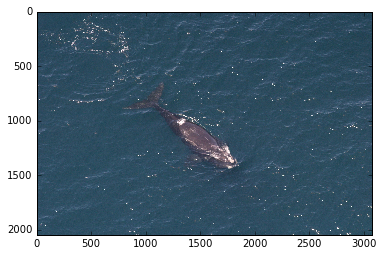

Total inference time: 10.4179191589 seconds


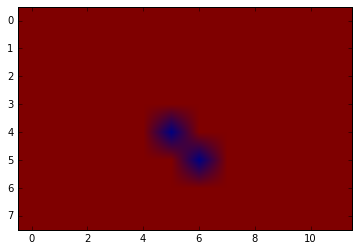

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import time

MODEL_JOB_NUM = '20161006-022552-8f93'  ## Remember to set this to be the job number for your model
DATASET_JOB_NUM = '20161006-021115-e07e'  ## Remember to set this to be the job number for your dataset

MODEL_FILE = '/home/ubuntu/digits/digits/jobs/' + MODEL_JOB_NUM + '/deploy.prototxt'                 # Do not change
PRETRAINED = '/home/ubuntu/digits/digits/jobs/' + MODEL_JOB_NUM + '/snapshot_iter_162.caffemodel'    # Do not change
MEAN_IMAGE = '/home/ubuntu/digits/digits/jobs/' + DATASET_JOB_NUM + '/mean.jpg'                      # Do not change

# load the mean image
mean_image = caffe.io.load_image(MEAN_IMAGE)

# Choose a random image to test against
RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = 'data/samples/w_' + RANDOM_IMAGE + '.jpg'                   

# Tell Caffe to use the GPU
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # subtract the mean image
        grid_square -= mean_image
        # make prediction
        prediction = net.predict([grid_square]) #classifier
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'


As you run the above code multiple times you will see that in some cases this baseline model and sliding window approach is able to locate the whale's face - more often it will find a larger amount of the whale.  But you will also see the model is easily confused by breaking waves or sunlight reflecting from the ocean surface.

<a id='question2'></a>
### Question 2

What are some ways we could improve the classification accuracy of this model?

Answer: [Click here](#answer2)

The fact that we used a sliding window with non-overlapping grid squares means that it is very likely that some of our grid squares will only partially contain a whale face and this can lead to misclassifications.  Unfortunately as we increase the overlap in the grid squares we will rapidly increase the computation time for this sliding window approach.  We also need to decide a method for combining overlapping classifications into a final classification "heatmap" - a popular approach for this is the non-maximal suppression (NMS) algorithm.

<a id='question3'></a>
### Question 3

How could we counteract that increased computation time required for overlapping grid squares?

Answer: [Click here](#answer3)

### Challenging optional exercises:

<a id='question-optional-exercise'></a>

1. Keeping the grid square size as 256x256, modify the code to increase the overlap between grid squares and obtain a finer classification map.

2. Modify the code to batch together multiple grid squares to pass in to the network for prediction.

Answer: [Click here](#answer-optional-exercise)

As we have seen the advantage of this sliding window approach is that we can train a detector using only patch based training data (which is more widely available).  However there are several disadvantages:

* slow to make predictions, especially if there is large overlap between grid squares which leads to a great deal of redundant computation
* challenging to produce a balanced training dataset that is robust to false alarm causing clutter
* difficult to achieve scale invariance for object detection

## Object detection approach 2: candidate generation and classification

We will not actually demonstrate this second approach but we describe it here for completeness. Instead of using a classification CNN in a sliding window fashion you can instead use some computationally cheaper, sensitive, but false alarm prone algorithm to generate candidate detections.  Examples of algorithms used for this process are cascade classifiers and selective search.  These candidate detections are then passed to the CNN to be classified by object type or filtered out as background noise.

These candidate generation algorithms will typically generate far fewer image patches to classify with the CNN than grid squares that need to be tested in a sliding window approach.  Furthermore, these candidate detections can be batched together before input into the CNN to benefit from parallelism.

Fig 3 shows how this approach would be used in a vehicle detection scenario.

![candidate generation example](candidate_generation_example.png)
<h4 align="center">Figure 3: CNN classifier with candidate generation pre-processing</h4> 

The benefits of this approach are:

* the speedup due to a smaller number of candidate detections to test
* depending on the candidate generation algorithm we may get more accurate localization of the object

The drawbacks of this approach are:

* a more complex multi-stage processing pipeline
* an additional model to build or train for candidate generation
* a non-trivial false alarm rate
* variable inference time dependent on the number of candidates generated

## Object detection approach 3: fully-convolutional network (FCN)

As mentioned earlier there is a great deal of redundant computation in the sliding window approach with overlapping windows.  Thankfully there is neat trick to avoid this redundancy.  The commonly used fully-connected layers towards the classification end of a CNN like Alexnet can be trivially replaced with convolutional layers.  These replacement layers have convolutional filters that are the same size as the feature map outputs for the previous layer and the number of filters is equal to the number of neurons in the fully-connected layer it replaces.  The benefit of making this replacement is that images of varying size can be input in to the network for classification.  If the input image is smaller than the expected image size for the network (called the receptive field of the network) then we will still just obtain a single classification for the image. However, if the image is larger than the receptive field then we will obtain a heatmap of classifications, much like we obtained from the sliding window approach.

Let's see how that works for AlexNet's `fc6` layer.
You can use DIGITS to inspect the shape of the input to `fc6`: using the CNN classifier that you just trained in the first part of this lab, check the box "Show visualizations and statistics" and test any arbitrary image.
You will see something like Figure 4 below:

![alexnet layers](alexnet_layers.png)
<h4 align="center">Figure 4: Alexnet FC6 layer</h4>

There you can see that `fc6` receives its input from `pool5`.
The shape of the activations at `pool5` is `256*6*6`.
The shape of the activations at `fc6` is `4096`, meaning that `fc6` has `4096` output neurons.
To turn `fc6` into an equivalent convolutional layer, we would need to create a convolutional layer with `6*6` kernel size and `4096` output feature maps.

Let's try this out with our whale detection problem.  Go back to DIGITS and clone your baseline whale face detection model using the "Clone" button in the top right corner of the model screen.

Now choose the "Customize" option alongside your selection of the Alexnet network architecture.

<a id='exercise1'></a>
### Exercise:

Replace the fully-connected (InnerProduct) layer `fc6` with a convolutional layer with a convolutional layer with 256 6x6 convolutional filters and zero padding. Similarly, replace `fc7` and `fc8` with equivalent convolutional layers.
See if you can successfully train this model.

Answer: [click here](#answer4)

Once you have made the required the changes the model should train and achieve approximately the same validation accuracy of ~98%.

Now we can use this model to directly compute the classification heatmap for an entire large aerial image.  Effectively we are still performing a sliding window classification but all of the sliding window process is efficiently handled within the FCN.

Run the code below to see this in action.  Again you will need to obtain your models job number and replace it in the code.

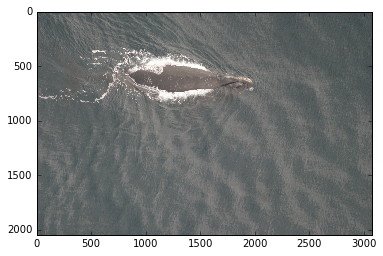

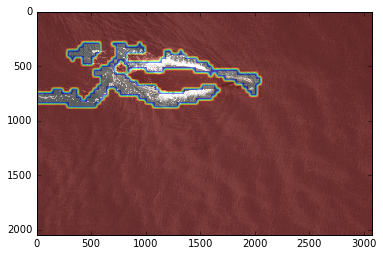

Total inference time: 5.39096689224 seconds


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import copy
from scipy.misc import imresize
import time

JOB_NUM = '20161006-025428-ed6a'  ## Remember to set this to be the job number for your model

MODEL_FILE = '/home/ubuntu/digits/digits/jobs/' + JOB_NUM + '/deploy.prototxt'                 # Do not change
PRETRAINED = '/home/ubuntu/digits/digits/jobs/' + JOB_NUM + '/snapshot_iter_108.caffemodel'    # Do not change

# Choose a random image to test against
RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = 'data/samples/w_' + RANDOM_IMAGE + '.jpg'                  

# Tell Caffe to use the GPU
caffe.set_mode_gpu()

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Initialize the Caffe model using the model trained in DIGITS
# This time the model input size is reshaped based on the randomly selected input image
net = caffe.Net(MODEL_FILE,PRETRAINED,caffe.TEST)
net.blobs['data'].reshape(1, 3, input_image.shape[0], input_image.shape[1])
net.reshape()
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

# This is just a colormap for displaying the results
my_cmap = copy.copy(plt.cm.get_cmap('jet')) # get a copy of the jet color map
my_cmap.set_bad(alpha=0) # set how the colormap handles 'bad' values

# Feed the whole input image into the model for classification
start = time.time()
out = net.forward(data=np.asarray([transformer.preprocess('data', input_image)]))
end = time.time()

# Create an overlay visualization of the classification result
im = transformer.deprocess('data', net.blobs['data'].data[0])
classifications = out['softmax'][0]
classifications = imresize(classifications.argmax(axis=0),input_image.shape,interp='bilinear').astype('float')
classifications[classifications==0] = np.nan
plt.imshow(im)
plt.imshow(classifications,alpha=.5,cmap=my_cmap)
plt.show()

# Display total time to perform inference
print 'Total inference time: ' + str(end-start) + ' seconds'

As you run the above code multiple times you will see that in many cases the FCN is able to locate the whale's face with greater precision than the sliding window approach. Often it will still find a larger amount of the whale and is sometimes confused by breaking waves or sunlight reflecting from the ocean surface. Again, the false alarms caused by background clutter and the whale's body could be mitigated using appropriate data augmentation.

Note that the total inference time for the FCN is about 1.5 seconds, wheras for the sliding window approach it took 10 seconds.  So we get a better quality result in a fraction of the time!  This is a great benefit if we wish to deploy our detector in a real-time application, e.g. on board an aircraft, as we obtain a single model that can perform detection and classification in one efficient pass.

In addition to data augmentation for our training data there are a couple of common ways to improve the classification accuracy and localization precision of an FCN approach.  The most common of these is to pass the input image through the network multiple times at varying scales.  This improves the models tolerance to scale variation in the appearance of the object of interest.  We can also modify the network layer strides to provide finer or coarser grained classification heatmap outputs.  By using multiple versions of the input image and classification network simultaneously and then performing a classification heatmap merging procedure we can improve the final classification and detection result drastically.  A well known example of this approach was presented in the paper OverFeat (Figure 5).

![overfeat](overfeat.png)
<h4 align="center">Figure 5: OverFeat method for improving detection resolution</h4> 

### Exercise:  

Now go back and modify the FCN test code to see the effect of passing different sized input images in to the network.  First, choose a fixed input image to test against.  Then manually resize that image before passing it in to the network.  Do this a few times and compare the effect on detection accuracy.

## Object detection approach 4: DetectNet

There is a final class of object approaches that train a CNN to simultaneously classify the most likely object present at each location within an image and predict the corresponding bounding box for that object through regression.  For example:

![yolo](yolo.png)

This approach has major benefits:

* Simple one-shot detection, classification and bounding box regression pipeline
* Very low latency
* Very low false alarm rates due to strong, voluminous background training data

In order to train this type of network specialized training data is required where all objects of interest are labelled with accurate bounding boxes.  This type of training data is much rarer and costly to produce; however, if this type of data is available for your object detection problem this is almost certainly the best approach to take. Fig 5 shows an example of a labelled training sample for a vehicle detection scenario.

![kespry example](kespry_example.png)
<h4 align="center">Figure 6: Labelled data for a three class object detection scenario</h4> 

The recent release of DIGITS 4 added the capability to train this class of model and provided a new "standard network" called DetectNet as an example.  We are going to use DetectNet to train a Right Whale detector in full-size aerial images of the ocean.  

The main challenge in training a single CNN for object detection and bounding box regression is in handling the fact that there can be varying numbers of objects present in different images.  In some cases you may even have an image with no objects at all.  DetectNet handles this problem by converting an image with an number of bounding box annotations to a fixed dimensionality data representation that we directly attempt to predict with a CNN.  Fig 6 shows how data is mapped to this represenation for a single class object detection problem.

![detectnet data rep](detectnet_data.png)
<h4 align="center">Figure 7: DetectNet data representation</h4> 

DetectNet is actually an FCN, as we described above, but configured to produce precisely this data representation as it's output.  The bulk of the layers in DetectNet are identical to the well known GoogLeNet network.  Fig 7 shows the DetectNet architecture for training.

![detectnet training architecture](detectnet_training.png)
<h4 align="center">Figure 8: DetectNet training architecture</h4> 

For the purposes of this lab we have already prepared the full-size aerial images of the ocean in the appropriate folders and format for training DetectNet.  We first need to import this data into DIGITS.  Use the Datasets->Images dropdown and select "object detection" dataset. When the "New Object Detection Dataset" panel opens, use the following preoprocessing options:

![OD data ingest](OD_ingest.png)

Now we will first look at how to train DetectNet on this dataset. A complete training run of DetectNet on this dataset takes several hours, so we have provided a trained model to experiment with.  Return to the main DIGITS screen and use the Models tab.  Open the "whale_detectnet" model and clone it.  Make the following changes:

* select your newly created "whales_detectnet" dataset
* change the number of training epochs to 3  
* change the batch size to 10

Feel free to explore the network architecture visually by clicking the "Visualize" button.  

When you're ready to train, give the model a new name like "whale_detectnet_2" and click "create".  Training this model for just 3 epochs will still take about 8 minutes, but you should see both the coverage and bounding box training and validation loss values decreasing already.  You will also see the mean Average Precision (mAP) score begin to rise.  mAP is a combined measure of how well the network is able to detect the whale faces and how accurate it's bounding box estimates were for the validation dataset.

Once the model has finished training return to the pre-trained "whale_detectnet" model.  You will see that after 100 training epochs this model had not only converged to low training and validation loss values, but also a high mAP score.  Let's test this trained model against a validation image to see if it can find the whale face.

Simply set the visualization method to "Bounding boxes" and paste the following image path in:  `/home/ubuntu/data/whale/data_336x224/val/images/000000118.png`.  Be sure to select the "Show visualizations and statistics" checkbox and then click "Test One".  You should see DetectNet successfully detects the whale face and draws a bounding box, like this:

![detectnet success](detectnet_success.png)

Feel free to test other images from the `/home/ubuntu/data/whale/data_336x224/val/images/` folder.  You will see that DetectNet is able to accurately detect most whale faces with a tightly drawn bounding box and has a very low false alarm rate.  Furthermore, inference is extremely fast with DetectNet.  Execute the following cell to use the Caffe command line interface to carry out an inference benchmark using the DetectNet architecture.  You should see that the average time taken to pass a single 336x224 pixel image forward through DetectNet is just 22ms.

In [ ]:
!caffe time --model /home/ubuntu/data/whale/deploy.prototxt --gpu 0

## Answers to questions:

<a id='answer1'></a>
### Answer 1

Random patches may end up containing whale faces too.  This is unlikely as the faces are typically only a very small part of the image and we have a large sample of random background patches which will almost entirely not contain whale faces.  We may also get whale bodies and tails in our background set, but this good as we are interested in localizing whale faces.

[Click here](#question1) to return to question 1

<a id='answer2'></a>
### Answer 2

Some good things to try would be to use a larger number of randomly selected non-face patches and to balance the dataset by augmenting the existing face patches with random rotations, flips and scalings.  You could also train a model with a larger number of trainable parameters such as GoogleNet.

[Click here](#question2) to return to question 2

<a id='answer3'></a>
### Answer 3

We could batch together multiple grid squares at a time to feed into the network for classification as a batch - that way we can further exploit parallelism and get computational acceleration from the GPU.

[Click here](#question3) to return to question 3

<a id='answer-optional-exercise'></a>

### Answer to optional exercise


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import time

MODEL_JOB_NUM = '20160920-092148-8c17'  ## Remember to set this to be the job number for your model
DATASET_JOB_NUM = '20160920-090913-a43d'  ## Remember to set this to be the job number for your dataset

MODEL_FILE = '/home/ubuntu/digits/digits/jobs/' + MODEL_JOB_NUM + '/deploy.prototxt'                 # Do not change
PRETRAINED = '/home/ubuntu/digits/digits/jobs/' + MODEL_JOB_NUM + '/snapshot_iter_270.caffemodel'    # Do not change
MEAN_IMAGE = '/home/ubuntu/digits/digits/jobs/' + DATASET_JOB_NUM + '/mean.jpg'                      # Do not change

# load the mean image
mean_image = caffe.io.load_image(MEAN_IMAGE)

# Choose a random image to test against
RANDOM_IMAGE = str(np.random.randint(10))
IMAGE_FILE = 'data/samples/w_' + RANDOM_IMAGE + '.jpg' 

# Tell Caffe to use the GPU
caffe.set_mode_gpu()
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

# Load the input image into a numpy array and display it
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)
plt.show()

# Calculate how many 256x256 grid squares are in the image
rows = input_image.shape[0]/256
cols = input_image.shape[1]/256

# Subtract the mean image
for i in range(0,rows):
    for j in range(0,cols):
        input_image[i*256:(i+1)*256,j*256:(j+1)*256] -= mean_image
        
# Initialize an empty array for the detections
detections = np.zeros((rows,cols))
        
# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (sliding window without overlap): ' + str(end-start) + ' seconds'

# define the amount of overlap between grid cells
OVERLAP = 0.25
grid_rows = int((rows-1)/(1-OVERLAP))+1
grid_cols = int((cols-1)/(1-OVERLAP))+1

print "Image has %d*%d blocks of 256 pixels" % (rows, cols)
print "With overlap=%f grid_size=%d*%d" % (OVERLAP, grid_rows, grid_cols)

# Initialize an empty array for the detections
detections = np.zeros((grid_rows,grid_cols))

# Iterate over each grid square using the model to make a class prediction
start = time.time()
for i in range(0,grid_rows):
    for j in range(0,grid_cols):
        start_col = j*256*(1-OVERLAP)
        start_row = i*256*(1-OVERLAP)
        grid_square = input_image[start_row:start_row+256, start_col:start_col+256]
        # make prediction
        prediction = net.predict([grid_square])
        detections[i,j] = prediction[0].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print ('Total inference time (sliding window with %f%% overlap: ' % (OVERLAP*100)) + str(end-start) + ' seconds'

# now with batched inference (one column at a time)
# we are not using a caffe.Classifier here so we need to do the pre-processing
# manually. The model was trained on random crops (256*256->227*227) so we
# need to do the cropping below. Similarly, we need to convert images
# from Numpy's Height*Width*Channel (HWC) format to Channel*Height*Width (CHW) 
# Lastly, we need to swap channels from RGB to BGR
net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
start = time.time()
net.blobs['data'].reshape(*[grid_cols, 3, 227, 227])

# Initialize an empty array for the detections
detections = np.zeros((rows,cols))

for i in range(0,rows):
    for j in range(0,cols):
        grid_square = input_image[i*256:(i+1)*256,j*256:(j+1)*256]
        # add to batch
        grid_square = grid_square[14:241,14:241] # 227*227 center crop        
        image = np.copy(grid_square.transpose(2,0,1)) # transpose from HWC to CHW
        image = image * 255 # rescale
        image = image[(2,1,0), :, :] # swap channels
        net.blobs['data'].data[j] = image
    # make prediction
    output = net.forward()[net.outputs[-1]]
    for j in range(0,cols):
        detections[i,j] = output[j].argmax()
end = time.time()
        
# Display the predicted class for each grid square
plt.imshow(detections)
plt.show()

# Display total time to perform inference
print 'Total inference time (batched inference): ' + str(end-start) + ' seconds'

[Click here](#question-optional-exercise) to return to question

<a id='answer4'></a>
### Answer 4

Replace layers fc6 through fc8 with the following. Then set the `bottom` blob of the `loss`, `accuracy` and `softmax` layers to `conv8`.

```layer {
  name: "conv6"
  type: "Convolution"
  bottom: "pool5"
  top: "conv6"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    pad: 0
    kernel_size: 6
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu6"
  type: "ReLU"
  bottom: "conv6"
  top: "conv6"
}
layer {
  name: "drop6"
  type: "Dropout"
  bottom: "conv6"
  top: "conv6"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv7"
  type: "Convolution"
  bottom: "conv6"
  top: "conv7"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 4096
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
layer {
  name: "relu7"
  type: "ReLU"
  bottom: "conv7"
  top: "conv7"
}
layer {
  name: "drop7"
  type: "Dropout"
  bottom: "conv7"
  top: "conv7"
  dropout_param {
    dropout_ratio: 0.5
  }
}
layer {
  name: "conv8"
  type: "Convolution"
  bottom: "conv7"
  top: "conv8"
  param {
    lr_mult: 1.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 2.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 2
    kernel_size: 1
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0.1
    }
  }
}
```

[Click here](#exercise1) to return to the exercise

### Thanks and data attribution

We would like to thank NOAA for their permission to re-use the Right Whale imagery for the purposes of this lab.

Images were collected under MMPA Research permit numbers:

MMPA 775-1600,      2005-2007

MMPA 775-1875,      2008-2013 

MMPA 17355,         2013-2018

Photo Credits: NOAA/NEFSC